In [166]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import serial
import sklearn as sks
import cv2
import matplotlib.pyplot as plt

In [167]:
# read image
img = cv2.imread('../IMG_0014.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape


(804, 1082, 3)

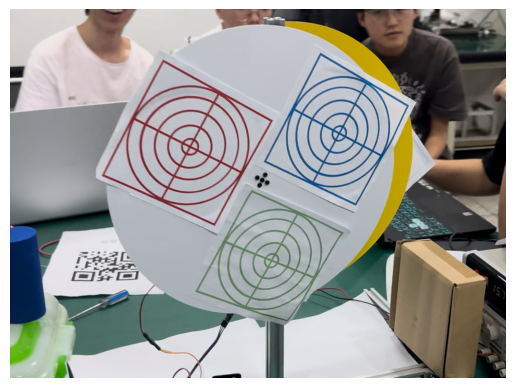

In [168]:
plt.imshow(img)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [169]:
# inverse covolution to reduce blur


In [170]:
# convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [171]:
# apply red mask
lower_red = np.array([166,65,73])
upper_red = np.array([177,173,134])
red_mask = cv2.inRange(hsv, lower_red, upper_red)


In [172]:
red_mask = cv2.GaussianBlur(red_mask, (3,3), 2)
# red_mask = cv2.medianBlur(red_mask, 5)


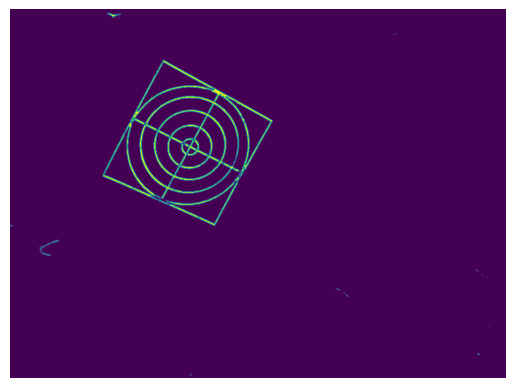

In [173]:
plt.imshow(red_mask)
plt.axis('off')
plt.show()

In [174]:
# 检测圆
red_circles = cv2.HoughCircles(red_mask, 
                           cv2.HOUGH_GRADIENT, 
                           dp=0.7, 
                           minDist=100,
                           param1=50+5,
                           param2=30+40,
                           minRadius=0,
                           maxRadius=0)

In [175]:
if red_circles is not None:
    red_circles = np.uint16(np.around(red_circles))
    for i in red_circles[0, :]:
        red_center = (i[0], i[1])  # 圆心
        red_radius = i[2]          # 圆半径
        cv2.circle(img, red_center, red_radius, (90, 230, 50), 3)  # 画圆
        cv2.circle(img, red_center, 2, (0, 255, 0), 3)       # 画圆心

In [176]:
red_mask = cv2.dilate(red_mask, None, iterations=2)  # 膨胀
red_mask = cv2.erode(red_mask, None, iterations=3)  # 腐蚀

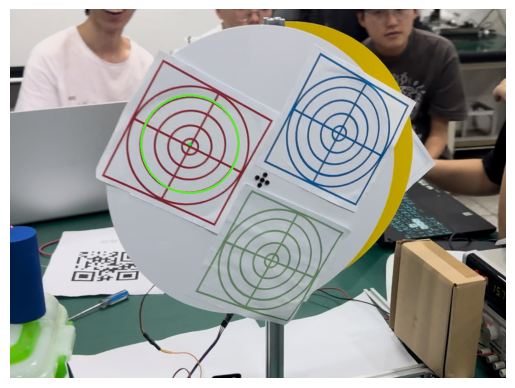

In [177]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [178]:
def non_max_suppression_lines(lines, rho_threshold=15, theta_threshold=np.pi/18):
    if lines is None:
        return []
    
    # 初始化
    nms_lines = []
    lines = sorted(lines, key=lambda x: x[0][0], reverse=True)  # 根据rho的值排序

    while len(lines) > 0:
        # 取出当前rho值最大的线条
        current_line = lines.pop(0)
        rho, theta = current_line[0]
        nms_lines.append(current_line)
        
        # 准备去除与当前线条过于接近的线条
        remaining_lines = []
        for line in lines:
            rho2, theta2 = line[0]
            # 计算rho和theta的差异
            rho_diff = abs(rho2 - rho)
            theta_diff = min(abs(theta2 - theta), np.pi - abs(theta2 - theta))
            # 仅保留差异足够大的线条
            if rho_diff > rho_threshold or theta_diff > theta_threshold:
                remaining_lines.append(line)
        # 更新列表
        lines = remaining_lines

    return nms_lines

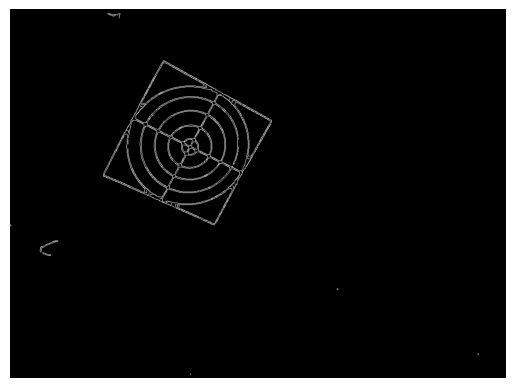

In [179]:
#检测直线 from red mask

edges = cv2.Canny(red_mask, 100, 200, apertureSize=3)
lines = cv2.HoughLines(edges, 0.65, np.pi/180, 100)
nms_lines = non_max_suppression_lines(lines)

# 对line进行局部最大值抑制

plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

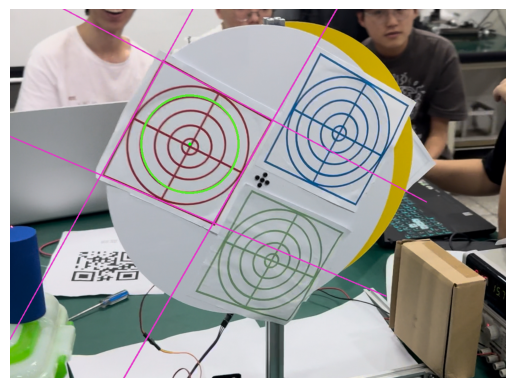

In [189]:
#draw lines from houghlines
for line in nms_lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)
    cv2.line(img, (x1, y1), (x2, y2), (230, 50, 200), 2)
plt.imshow(img)
plt.axis('off')
plt.show()

In [190]:
shifted_image = cv2.pyrMeanShiftFiltering(img, 21, 51)

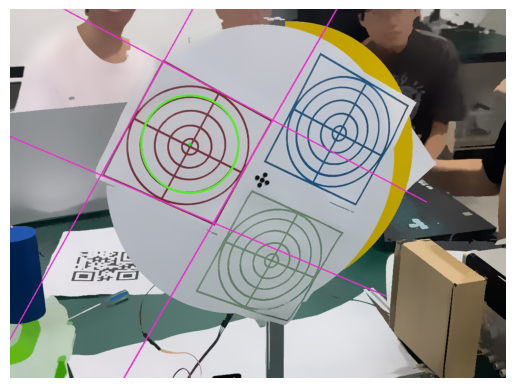

In [191]:
plt.imshow(shifted_image)
plt.axis('off')
plt.show()
